# Simulation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scvi

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scp.simulations as sm
import scp.plots as pl
from scp.models import PROTVI

scvi.settings.seed = 0


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scp/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scp/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/scp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0


## Generation

In [2]:
n_datasets = 10
sm.fix_seed(0)

datasets = []
for i in range(n_datasets):
    
    adata = sm.simulate_two_groups(n_de_proteins=300, log2_fold_change=1.5)
    # adata = sm.simulate_group()
    datasets.append(adata)

## Inspection

Let's look at one of the simulated datasets.

In [3]:
adata = datasets[2].copy()

print(f"Number of cells: {adata.n_obs}")
print(f"Number of proteins: {adata.n_vars}")

mask = adata.layers["detected"]
n_obs = np.mean(mask)

print(f"Observed intensities: {n_obs*100:.2f}%")

Number of cells: 1000
Number of proteins: 900
Observed intensities: 74.75%


Let's look at the expression matrix.

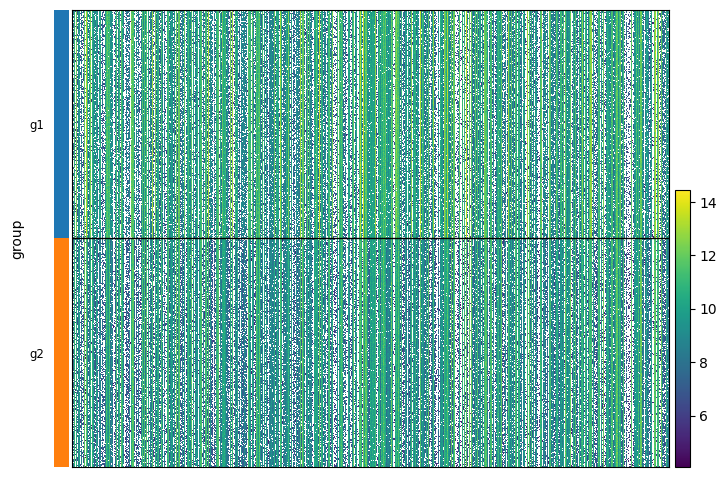

In [4]:
adata.X = adata.layers["intensity"].copy()
adata.X[adata.layers["detected"] == 0] = np.nan

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="group", show_gene_labels=False,)

Text(0.5, 1.0, '')

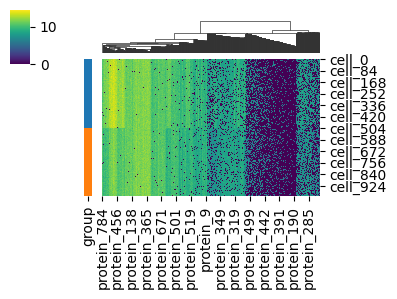

In [5]:
adata_ = adata.copy()
adata_.X = adata_.layers["intensity"].copy()
adata_.X[adata_.layers["detected"] == 0] = 0

lut = dict(zip(adata_.obs.group.unique(), ['#1f77b4', '#ff7f0e']))
row_colors = adata_.obs.group.map(lut)


g = sns.clustermap(adata_.to_df(), row_colors= row_colors, figsize=(4, 3), col_cluster=True, row_cluster=False, cmap="viridis")
g.ax_heatmap.set_title('')

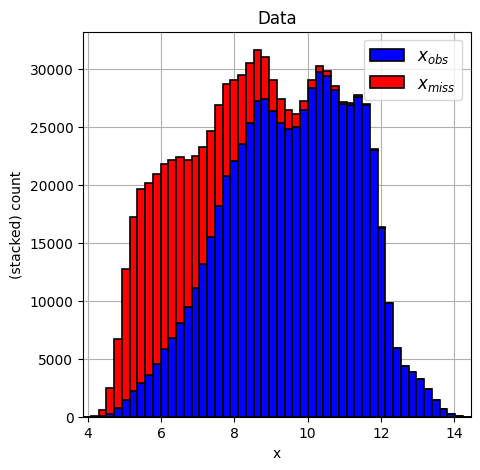

In [6]:
mask = adata.layers["detected"]
x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

Let's look at the protein detection proportion and intensity.

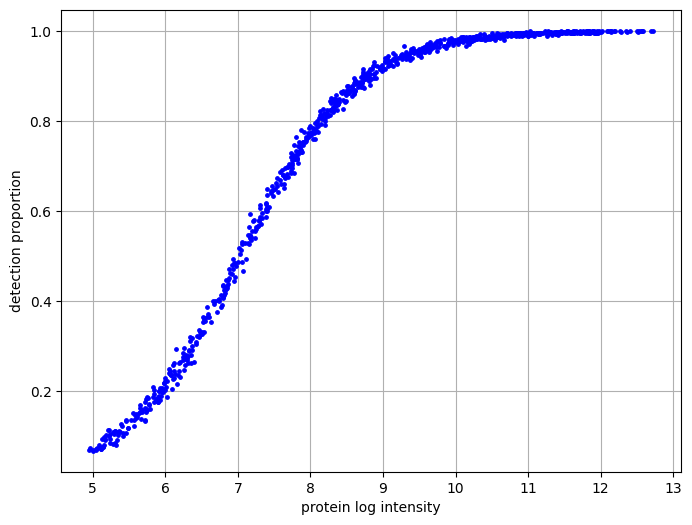

In [7]:
pl.scatter_protein_detection_proportion_and_intensity(adata.X)

In [8]:
# mask.sum(0)/1000

In [9]:
# adata.var.detection_probability

## Modelling

Let's fit a few models to the data.

### PROTVI

In [10]:
adata = datasets[3].copy()

In [11]:
# adata.X

In [12]:
sc.pp.pca(adata)

In [13]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

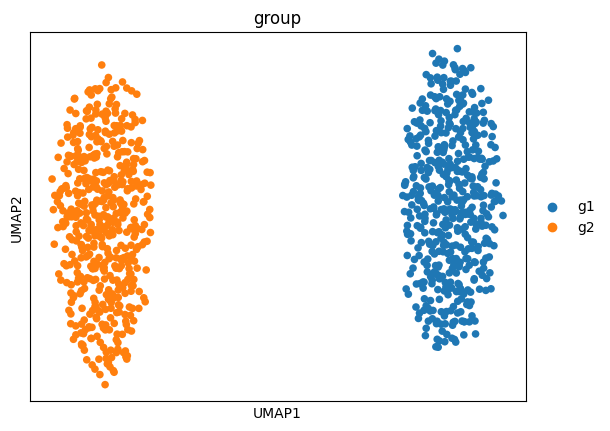

In [14]:
sc.pl.umap(adata, color = 'group')

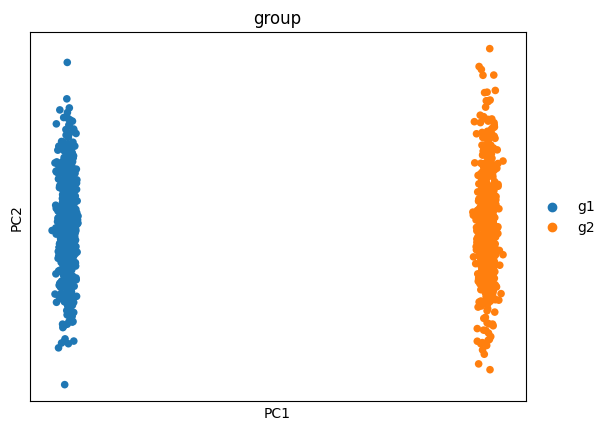

In [15]:
sc.pl.pca(adata, color = 'group')

In [16]:
adata.X = adata.layers["intensity"].copy() * adata.layers["detected"].copy()

In [17]:
PROTVI.setup_anndata(adata)

model = PROTVI(adata, log_variational=False)
#model.view_anndata_setup()

In [18]:
model.train(max_epochs=800, plan_kwargs={"lr": 3e-3, "mechanism_weight":0.0})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 800/800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:50<00:00,  7.20it/s, v_num=1, train_loss_step=987, train_loss_epoch=1e+3]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 800/800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:50<00:00,  7.23it/s, v_num=1, train_loss_step=987, train_loss_epoch=1e+3]


In [19]:
model

PROTVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: , latent_distribution: 0.1
Training status: Trained
Model's adata is minified?: False

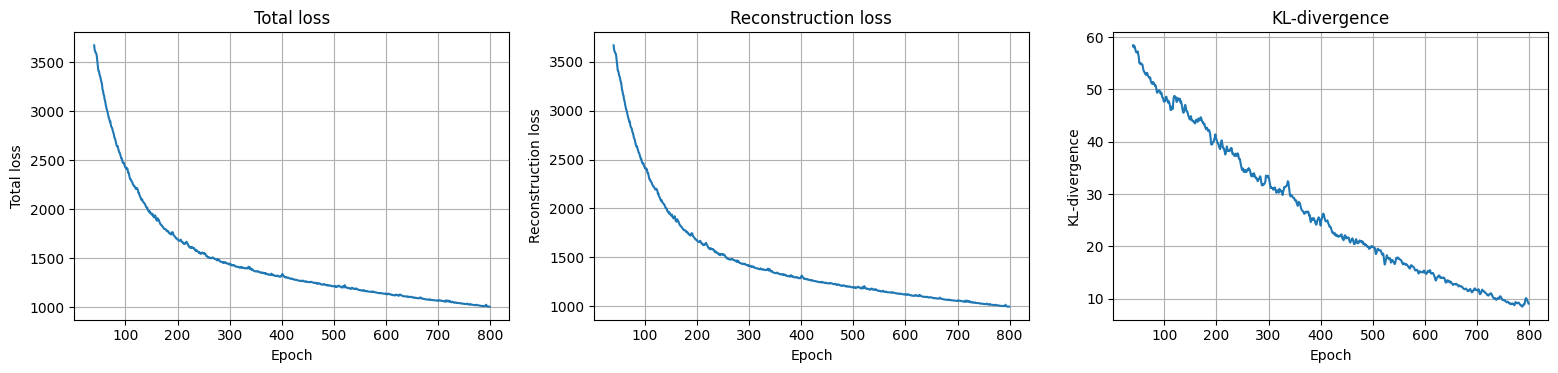

In [20]:
pl.plot_loss(model.history, n_skip=40)

In [21]:
adata.obsm['X_protVI'] = model.get_latent_representation()

In [22]:
sc.pp.neighbors(adata, use_rep = 'X_protVI')
sc.tl.umap(adata)

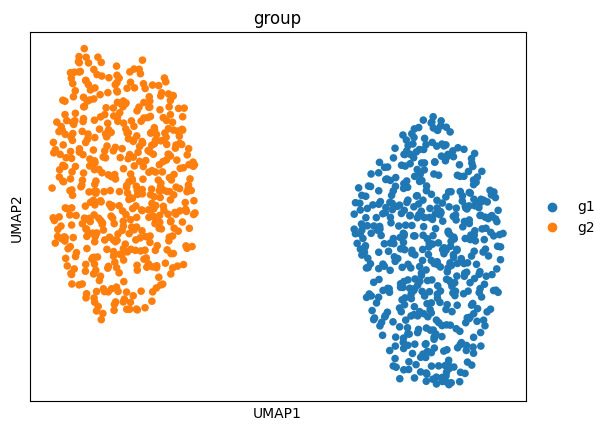

In [23]:
sc.pl.umap(adata, color = 'group')

In [24]:
# sc.pl.pca(adata, color = 'group')

In [25]:
x_est, p_est = model.impute(adata)

In [26]:
x_est.shape

(1000, 900)

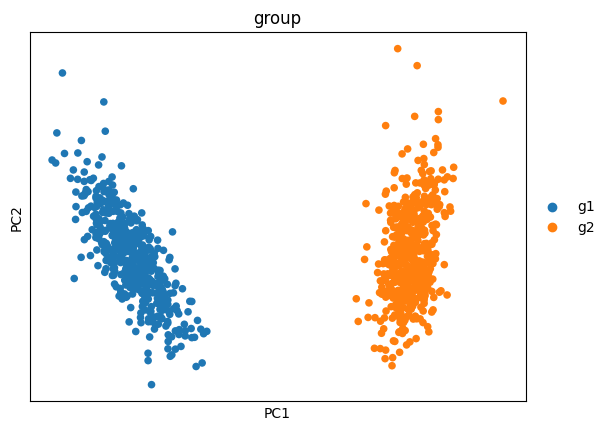

In [27]:
emb = sc.AnnData(X = adata.obsm['X_protVI'].copy(), obs = adata.obs)
sc.pp.pca(emb)
sc.pl.pca(emb, color = 'group')

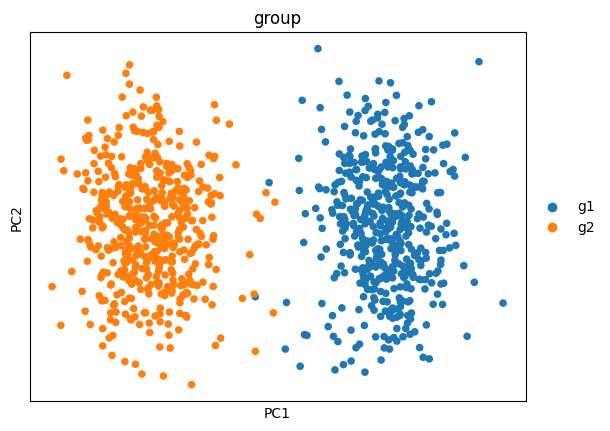

In [28]:
adata_imp = sc.AnnData(X = x_est, obs = adata.obs)
sc.pp.pca(adata_imp)
sc.pl.pca(adata_imp, color = 'group')

In [29]:
# adata.layers["detected"].sum(1)

In [30]:
# (p_est < 0.8).sum(1)

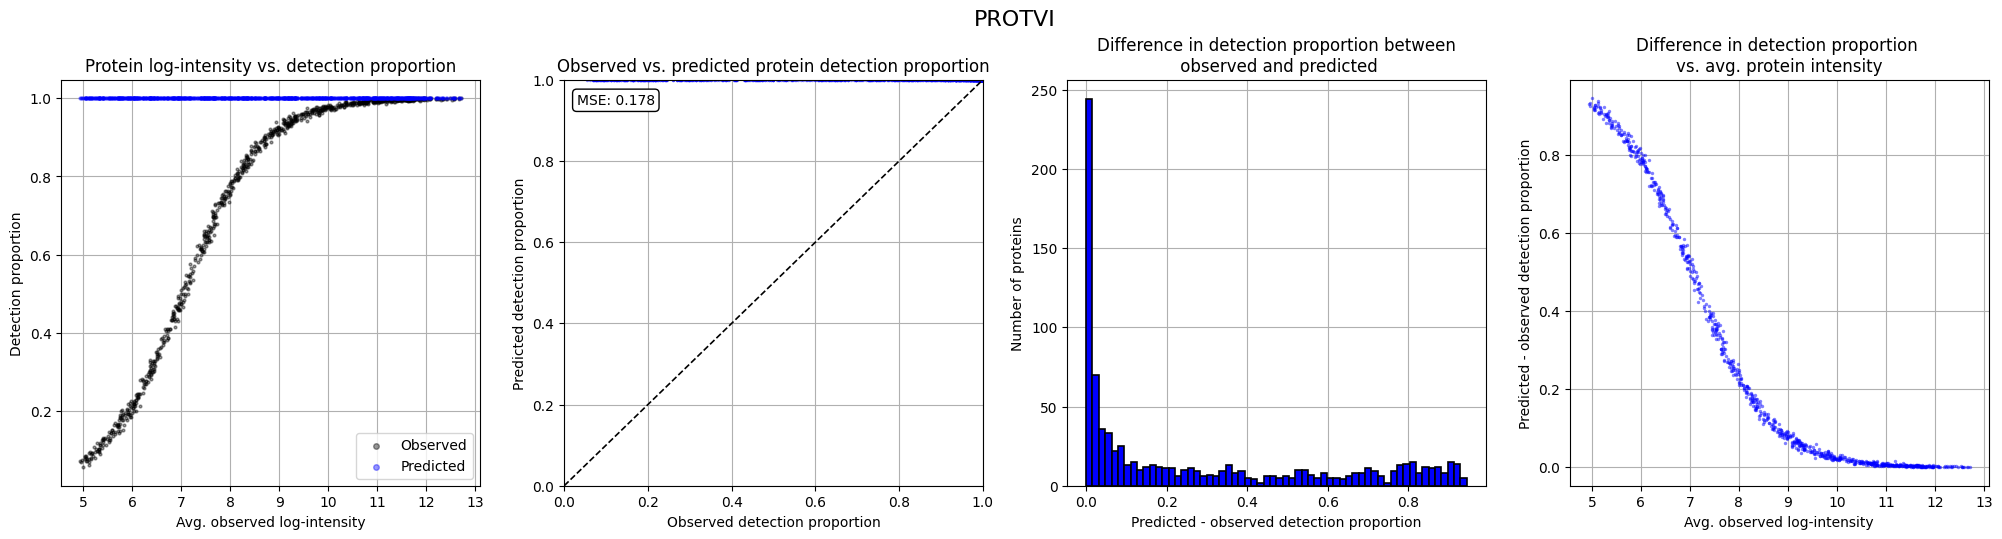

In [31]:
x_data = adata.layers["intensity"].copy()
x_data[~adata.layers["detected"]] = np.nan

pl.plot_protein_detection_proportion_panel(x_data, p_est)

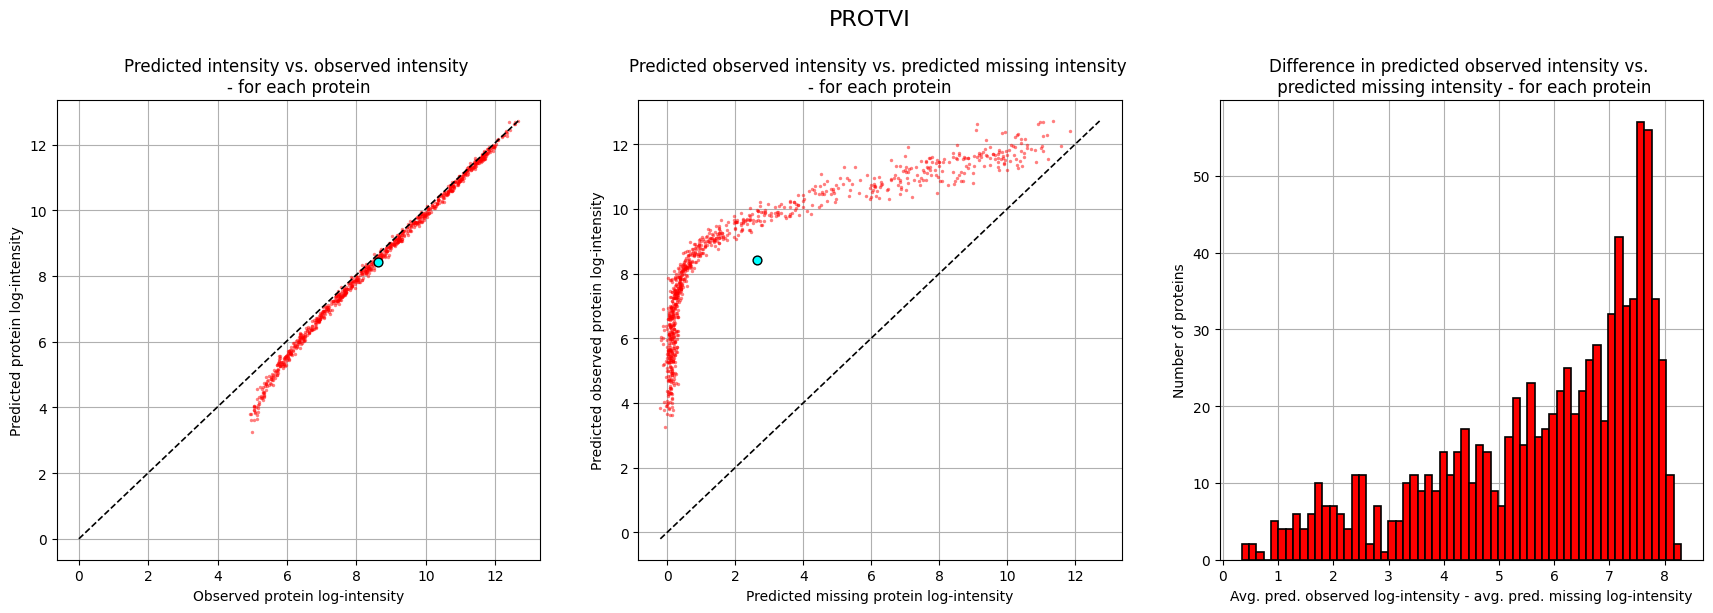

In [32]:
pl.plot_protein_intensity_panel(x_data, x_est, title="PROTVI")

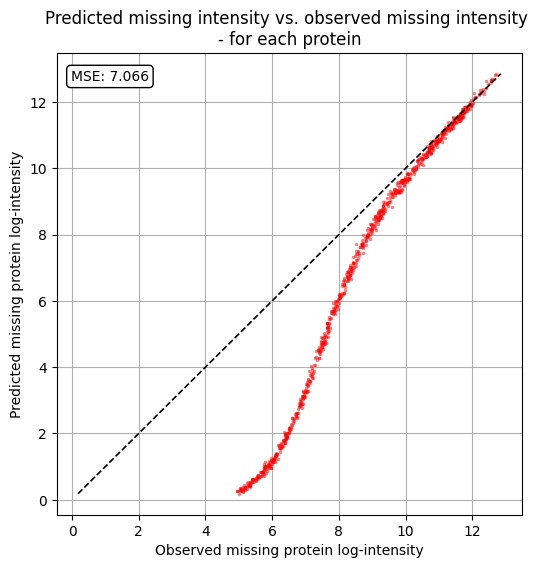

In [33]:
mask = adata.layers["detected"]

x_est_protein = np.nanmean(x_est * mask, axis=0)
x_protein = np.nanmean(x_data * mask, axis=0)

pl.scatter_compare_protein_missing_intensity(x_protein, x_est_protein)

In [34]:
mask = adata.layers["detected"]

x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

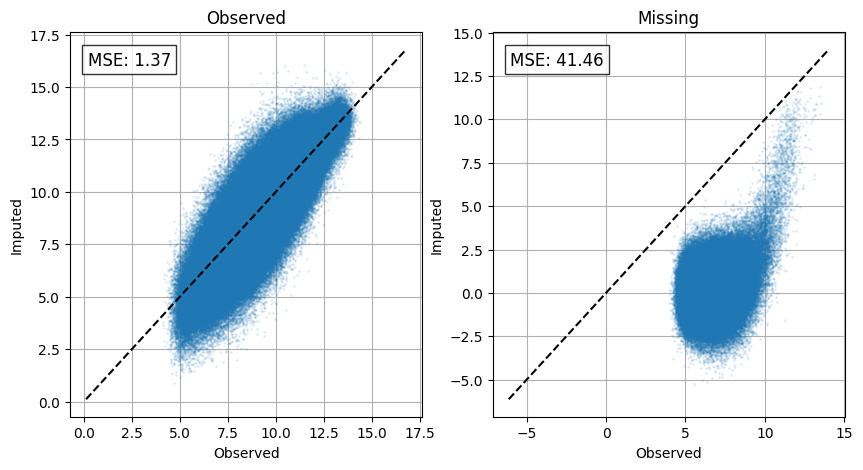

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(x_obs, x_est_obs, s=1, alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "--", c="k")

mse = np.mean((x_obs - x_est_obs)**2)
ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

ax.set_xlabel("Observed")
ax.set_ylabel("Imputed")
ax.set_title("Observed")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(x_miss, x_est_miss, s=1, alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "--", c="k")

mse = np.mean((x_miss - x_est_miss)**2)
ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

ax.set_xlabel("Observed")
ax.set_ylabel("Imputed")
ax.set_title("Missing")
ax.grid(True)
ax.set_axisbelow(True)

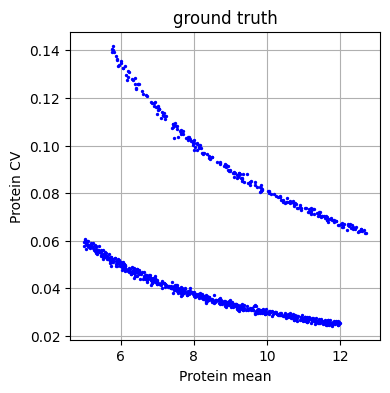

In [36]:
pl.scatter_protein_mean_and_cv(x, title = "ground truth")

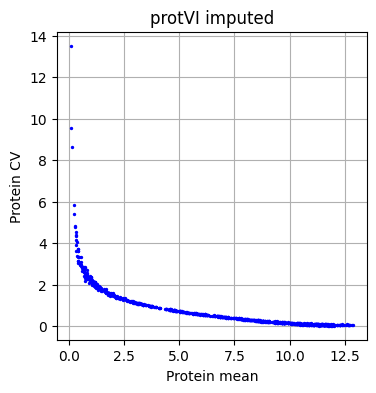

In [37]:
pl.scatter_protein_mean_and_cv(x_est, title = "protVI imputed")

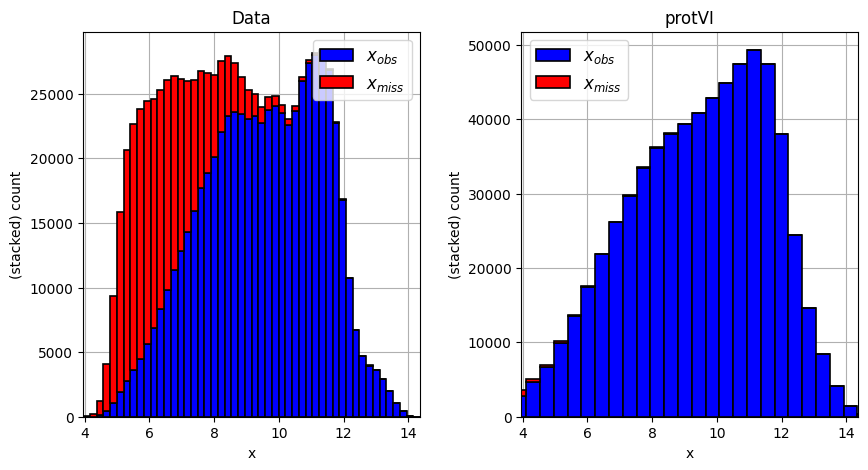

In [38]:
mask = adata.layers["detected"]
x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

ax = axes[1]
ax.hist([x_est_obs, x_est_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("protVI")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

### protDP

In [39]:
# @TODO

### Other impuation methods

In [40]:
# @TODO